<a href="https://colab.research.google.com/github/victorviro/Deep_learning_python/blob/master/Autoencoders_explained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Autoencoders

## Introduction

Autoencoders are artificial neural networks capable of learning dense representations of the input data, called *latent representations* or *codings*, without any supervision (i.e., the training set is unlabeled). These codings typically have a much lower dimensionality than the input data, making autoencoders useful for dimensionality reduction (see notebook [Dimensionality reduction](https://github.com/victorviro/ML_algorithms_python/blob/master/Dimensionality_reduction_algorithms.ipynb)), especially for visualization purposes. Autoencoders also act as feature detectors, and they can be used for unsupervised pretraining of deep neural networks. Lastly, some autoencoders are generative models: they are capable of randomly generating new data that looks very similar to the training data. For example, we could train an autoencoder on pictures of faces, and it would then be able to generate new faces. However, the generated images are usually fuzzy and not entirely realistic. However, generative adversarial networks (GANs) are state of the art models for this purpose.





Autoencoders and GANs are both unsupervised, they both learn dense representations, they can both be used as generative models, and they have many similar applications. However, they work very differently:


- Autoencoders simply learn to copy their inputs to their outputs. This may sound like a trivial task, but we will see that constraining the network in various ways can make it rather difficult. For example, we can limit the size of the latent representations, or we can add noise to the inputs and train the network to recover the original inputs. These constraints prevent the autoencoder from trivially copying the inputs directly to the outputs, which forces it to learn efficient ways of representing the data. In short, the codings are byproducts of the autoencoder learning the identity function under some constraints.

- GANs are composed of two neural networks: a generator that tries to generate data that looks similar to the training data, and a discriminator that tries to tell real data from fake data. This architecture is very original in Deep Learning in that the generator and the discriminator compete against each other during training: the generator is often compared to a criminal trying to make realistic counterfeit money, while the discriminator is like the police investigator trying to tell real money from fake. Adversarial training (training competing neural networks) is widely considered as one of the most important ideas in recent years. In 2016, Yann LeCun even said that it was "the most interesting idea in the last 10 years in Machine Learning".

In this chapter we will start by exploring in more depth how autoencoders work and how to use them for dimensionality reduction, feature extraction, unsupervised pretraining, or as generative models. This will naturally lead us to GANs which we will study in the next notebook. 


## Efficient Data Representations

Which of the following number sequences do you find the easiest to memorize?

- 40, 27, 25, 36, 81, 57, 10, 73, 19, 68

- 50, 48, 46, 44, 42, 40, 38, 36, 34, 32, 30, 28, 26, 24, 22, 20, 18, 16, 14

At first glance, it would seem that the first sequence should be easier, since it is much shorter. However, if we look carefully at the second sequence, we will notice that it is just the list of even numbers from 50 down to 14. Once we notice this pattern, the second sequence becomes much easier to memorize than the first because we only need to remember the pattern (i.e., decreasing even numbers) and the starting and ending numbers (i.e., 50 and 14). Note that if we could quickly and easily memorize very long sequences, we would not care much about the existence of a pattern in the second sequence. We would just learn every number by heart, and that would be that. The fact that it is hard to memorize long sequences is what makes it useful to recognize patterns, and hopefully this clarifies why constraining an autoencoder during training pushes it to discover and exploit patterns in the data.

The relationship between memory, perception, and pattern matching was famously studied by William Chase and Herbert Simon in the early 1970s ([paper](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.601.2724&rep=rep1&type=pdf)). They observed that expert chess players were able to memorize the positions of all the pieces in a game by looking at the board for just five seconds, a task that most people would find impossible. However, this was only the case when the pieces were placed in realistic positions (from actual games), not when the pieces were placed randomly. Chess experts don’t have a much better memory than you and I; they just see chess patterns more easily, thanks to their experience with the game. Noticing patterns helps them store information efficiently.

Just like the chess players in this memory experiment, an autoencoder looks at the inputs, converts them to an efficient latent representation, and then spits out something that (hopefully) looks very close to the inputs. An autoencoder is always composed of two parts: an *encoder* (or *recognition network*) that converts the inputs to a latent representation, followed by a *decoder* (or *generative network*) that converts the internal representation to the outputs (see Figure 17-1).

![](https://i.ibb.co/wNrTMXh/autoencoder-chess.png)

As we can see, an autoencoder typically has the same architecture as a Multi-Layer Perceptron (MLP; see notebook [Introduction to ANNs](https://github.com/victorviro/Deep_learning_python/blob/master/Introduction_artificial_neural_networks.ipynb)), except that the number of neurons in the output layer must be equal to the number of inputs. In this example, there is just one hidden layer composed of two neurons (the encoder), and one output layer composed of three neurons (the decoder). The outputs are often called the *reconstructions* because the autoencoder tries to reconstruct the inputs, and the cost function contains a reconstruction loss that penalizes the model when the reconstructions are different from the inputs.

Because the internal representation has a lower dimensionality than the input data (it is 2D instead of 3D), the autoencoder is said to be *undercomplete*. An undercomplete autoencoder cannot trivially copy its inputs to the codings, yet it must find a way to output a copy of its inputs. It is forced to learn the most important features in the input data (and drop the unimportant ones).

Let’s see how to implement a very simple undercomplete autoencoder for dimensionality reduction.

## Performing PCA with an Undercomplete Linear Autoencoder

If the autoencoder uses only linear activations and the cost function is the mean squared error (MSE), then it ends up performing Principal Component Analysis (PCA; see notebook [Dimensionality reduction](https://github.com/victorviro/ML_algorithms_python/blob/master/Dimensionality_reduction_algorithms.ipynb)).

The following code builds a simple linear autoencoder to perform PCA on a 3D dataset, projecting it to 2D:

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from tensorflow import keras
import tensorflow as tf

In [2]:
# First, build a 3D dataset
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

In [3]:
np.random.seed(42)
tf.random.set_seed(42)

# Now, build the Autoencoder...
encoder = keras.models.Sequential([keras.layers.Dense(2, input_shape=[3])])
decoder = keras.models.Sequential([keras.layers.Dense(3, input_shape=[2])])
autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1.5))

This code is really not very different from all the MLPs we built in past notebooks, but there are a few things to note:

- We organized the autoencoder into two subcomponents: the encoder and the decoder. Both are regular Sequential models with a single `Dense` layer each, and the autoencoder is a Sequential model containing the encoder followed by the decoder (remember that a model can be used as a layer in another model).

- The autoencoder’s number of outputs is equal to the number of inputs (i.e., 3).

- To perform simple PCA, we do not use any activation function (i.e., all neurons are linear), and the cost function is the MSE. We will see more complex autoencoders shortly.

Now let’s train the model on a simple generated 3D dataset and use it to encode that same dataset (i.e., project it to 2D):


In [4]:
history = autoencoder.fit(X_train, X_train, epochs=20)

Epoch 1/20
2/2 [==============================] - 0s 3ms/step - loss: 0.2547
Epoch 2/20
2/2 [==============================] - 0s 2ms/step - loss: 0.1032
Epoch 3/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0551
Epoch 4/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0503
Epoch 5/20
2/2 [==============================] - 0s 1ms/step - loss: 0.0839
Epoch 6/20
2/2 [==============================] - 0s 2ms/step - loss: 0.2223
Epoch 7/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0913
Epoch 8/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0320
Epoch 9/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0242
Epoch 10/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0189
Epoch 11/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0142
Epoch 12/20
2/2 [==============================] - 0s 2ms/step - loss: 0.0102
Epoch 13/20
2/2 [==============================] - 0s 1ms/step - loss: 0.

In [5]:
codings = encoder.predict(X_train)

Note that the same dataset, `X_train`, is used as both the inputs and the targets. Figure 17-2 shows the original 3D dataset (on the left) and the output of the autoencoder’s hidden layer (i.e., the coding layer, on the right). As we can see, the autoencoder found the best 2D plane to project the data onto, preserving as much variance in the data as it could (just like PCA).

![](https://i.ibb.co/mX8K9JK/PCA-autoencoder.png)



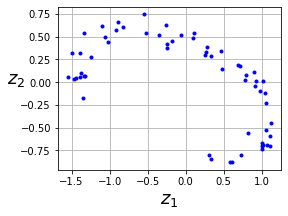

In [6]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

**Note**: We can think of autoencoders as a form of self-supervised learning (i.e., using a supervised learning technique with automatically generated labels, in this case simply equal to the inputs).

## Stacked Autoencoders

Just like other neural networks we have discussed, autoencoders can have multiple hidden layers. In this case they are called *stacked autoencoders* (or *deep autoencoders*). Adding more layers helps the autoencoder learn more complex codings. That said, one must be careful not to make the autoencoder too powerful. Imagine an encoder so powerful that it just learns to map each input to a single arbitrary number (and the decoder learns the reverse mapping). Obviously such an autoencoder will reconstruct the training data perfectly, but it will not have learned any useful data representation in the process (and it is unlikely to generalize well to new instances).

The architecture of a stacked autoencoder is typically symmetrical with regard to the central hidden layer (the coding layer). To put it simply, it looks like a sandwich. For example, an autoencoder for [Fashion-MNIST](https://github.com/zalandoresearch/fashion-mnist) may have 784 inputs, followed by a hidden layer with 100 neurons, then a central hidden layer of 30 neurons, then another hidden layer with 100 neurons, and an output layer with 784 neurons. This stacked autoencoder is represented in Figure 17-3.

![](https://i.ibb.co/Xpry7t1/stacked-autoencoder.png)

### Implementing a Stacked Autoencoder Using Keras

We can implement a stacked autoencoder very much like a regular deep MLP. For example, the following code builds a stacked autoencoder for Fashion-MNIST, using the SELU activation function:

In [7]:
# load and normalize Fashion MNIST dataset
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]



In [8]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

tf.random.set_seed(42)
np.random.seed(42)

stacked_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu"),
])
stacked_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss="binary_crossentropy",
                   optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])


Let’s go through this code:

- Just like earlier, we split the autoencoder model into two submodels: the encoder and the decoder.

- The encoder takes $28 \times 28$ pixel grayscale images, flattens them so that each image is represented as a vector of size 784, then processes these vectors through two `Dense` layers of diminishing sizes (100 units then 30 units), both using the SELU activation function (we may want to add LeCun normal initialization as well, but the network is not very deep so it won’t make a big difference). For each input image, the encoder outputs a vector of size 30.

- The decoder takes codings of size 30 (output by the encoder) and processes them through two Dense layers of increasing sizes (100 units then 784 units), and it reshapes the final vectors into 28 × 28 arrays so the decoder’s outputs have the same shape as the encoder’s inputs.

- When compiling the stacked autoencoder, we use the binary cross-entropy loss instead of the mean squared error. We are treating the reconstruction task as a multilabel binary classification problem: each pixel intensity represents the probability that the pixel should be black. Framing it this way (rather than as a regression problem) tends to make the model converge faster.

Finally, we train the model using `X_train` as both the inputs and the targets (and similarly, we use `X_valid` as both the validation inputs and targets).



In [9]:
history = stacked_ae.fit(X_train, X_train, epochs=10,
                         validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3381 - rounded_accuracy: 0.8870 - val_loss: 0.3164 - val_rounded_accuracy: 0.9007
Epoch 2/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.3056 - rounded_accuracy: 0.9152 - val_loss: 0.3021 - val_rounded_accuracy: 0.9200
Epoch 3/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2986 - rounded_accuracy: 0.9215 - val_loss: 0.2987 - val_rounded_accuracy: 0.9196
Epoch 4/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2948 - rounded_accuracy: 0.9249 - val_loss: 0.2938 - val_rounded_accuracy: 0.9286
Epoch 5/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2923 - rounded_accuracy: 0.9272 - val_loss: 0.2919 - val_rounded_accuracy: 0.9286
Epoch 6/10
1719/1719 [==============================] - 4s 2ms/step - loss: 0.2904 - rounded_accuracy: 0.9289 - val_loss: 0.2914 - val_rounded_accuracy: 0.9305
Epoch 7/10
1719/1719 [==================

### Visualizing the Reconstructions

One way to ensure that an autoencoder is properly trained is to compare the inputs and the outputs: the differences should not be too significant. Let’s plot a few images from the validation set, as well as their reconstructions:

This function processes a few test images through the autoencoder and displays the original images and their reconstructions:

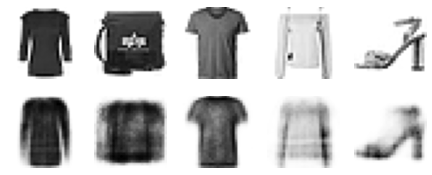

In [10]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

def show_reconstructions(model, images=X_valid, n_images=5):
    reconstructions = model.predict(X_valid[:n_images])
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(X_valid[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])

show_reconstructions(stacked_ae)

The reconstructions are recognizable, but a bit too lossy. We may need to train the model for longer, or make the encoder and decoder deeper, or make the codings larger. But if we make the network too powerful, it will manage to make perfect reconstructions without having learned any useful patterns in the data. For now, let’s go with this model.

### Visualizing the Fashion MNIST Dataset

Now that we have trained a stacked autoencoder, we can use it to reduce the dataset’s dimensionality. For visualization, this does not give great results compared to other dimensionality reduction algorithms (such as those we discussed in notebook [Dimensionality reduction](https://github.com/victorviro/ML_algorithms_python/blob/master/Dimensionality_reduction_algorithms.ipynb)), but one big advantage of autoencoders is that they can handle large datasets, with many instances and many features. So one strategy is to use an autoencoder to reduce the dimensionality down to a reasonable level, then use another dimensionality reduction algorithm for visualization. Let’s use this strategy to visualize Fashion MNIST. First, we use the encoder from our stacked autoencoder to reduce the dimensionality down to 30, then we use Scikit-Learn’s implementation of the t-SNE algorithm to reduce the dimensionality down to 2 for visualization:

In [11]:
np.random.seed(42)
from sklearn.manifold import TSNE

X_valid_compressed = stacked_encoder.predict(X_valid)
tsne = TSNE()
X_valid_2D = tsne.fit_transform(X_valid_compressed)

Now we can plot the dataset:

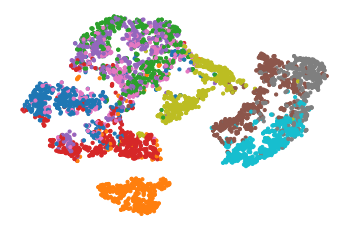

In [12]:
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap="tab10")
plt.axis("off")
plt.show()

Let's make this diagram a bit prettier:

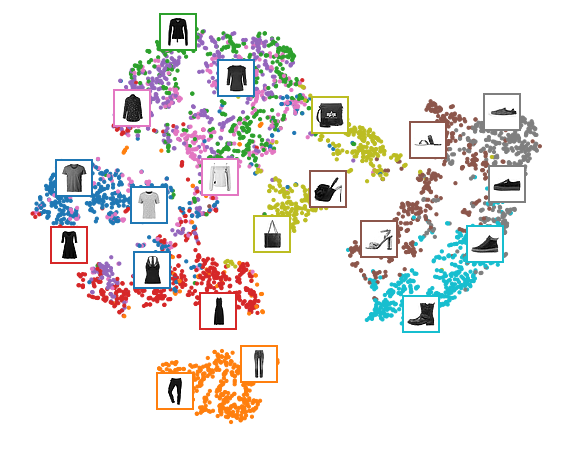

In [13]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
import matplotlib as mpl

plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid, s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

The t-SNE algorithm identified several clusters which match the classes reasonably well (each class is represented with a different color).

So, autoencoders can be used for dimensionality reduction. Another application is for unsupervised pretraining.

### Unsupervised Pretraining Using Stacked Autoencoders

As we discussed in the notebook [Reusing pretrained layers](https://github.com/victorviro/Deep_learning_python/blob/master/Reusing_pretrained_layers_DNNs.ipynb), if we are tackling a complex supervised task but we do not have a lot of labeled training data, one solution is to find a neural network that performs a similar task and reuse its lower layers. This makes it possible to train a high-performance model using little training data because our neural network won’t have to learn all the low-level features; it will just reuse the feature detectors learned by the existing network.

Similarly, if we have a large dataset but most of it is unlabeled, we can first train a stacked autoencoder using all the data, then reuse the lower layers to create a neural network for our actual task and train it using the labeled data. For example, Figure 17-6 shows how to use a stacked autoencoder to perform unsupervised pretraining for a classification neural network. When training the classifier, if we really don’t have much labeled training data, we may want to freeze the pretrained layers (at least the lower ones).

![](https://i.ibb.co/my205py/unsupervised-pretraining-autoencoders.png)

**Note**: Having plenty of unlabeled data and little labeled data is common. Building a large unlabeled dataset is often cheap (e.g., a simple script can download millions of images off the internet), but labeling those images (e.g., classifying them as cute or not) can usually be done reliably only by humans. Labeling instances is time-consuming and costly, so it’s normal to have only a few thousand human-labeled instances.

There is nothing special about the implementation: just we can train an autoencoder using all the training data (labeled plus unlabeled), then reuse its encoder layers to create a new neural network (see the exercises at the end of this [notebook](https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb) for an example).

Next, let’s look at a few techniques for training stacked autoencoders.


### Tying Weights

When an autoencoder is neatly symmetrical, like the one we just built, a common technique is to tie the weights of the decoder layers to the weights of the encoder layers. This halves the number of weights in the model, speeding up training and limiting the risk of overfitting. Specifically, if the autoencoder has a total of $N$ layers (not counting the input layer), and $\boldsymbol{W}_L$ represents the connection weights of the $L^{\text{th}}$ layer (e.g., layer 1 is the first hidden layer, layer $\frac{N}{2}$ is the coding layer, and layer $N$ is the output layer), then the decoder layer weights can be defined simply as: 

$$\boldsymbol{W}_{N-L+1}=\boldsymbol{W}_L^T$$

with $L=1,2,...,\frac{N}{2}$.

To tie weights between layers using Keras, let’s define a custom layer:

In [14]:
class DenseTranspose(keras.layers.Layer):
    def __init__(self, dense, activation=None, **kwargs):
        self.dense = dense
        self.activation = keras.activations.get(activation)
        super().__init__(**kwargs)
    def build(self, batch_input_shape):
        self.biases = self.add_weight(name="bias",
                                      shape=[self.dense.input_shape[-1]],
                                      initializer="zeros")
        super().build(batch_input_shape)
    def call(self, inputs):
        z = tf.matmul(inputs, self.dense.weights[0], transpose_b=True)
        return self.activation(z + self.biases)

This custom layer acts like a regular `Dense` layer, but it uses another Dense layer’s weights, transposed (setting `transpose_b=True` is equivalent to transposing the second argument, but it’s more efficient as it performs the transposition on the fly within the `matmul()` operation). However, it uses its own bias vector. Next, we can build a new stacked autoencoder, much like the previous one, but with the decoder’s Dense layers tied to the encoder’s `Dense` layers:

In [15]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

dense_1 = keras.layers.Dense(100, activation="selu")
dense_2 = keras.layers.Dense(30, activation="selu")

tied_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    dense_1,
    dense_2
])

tied_decoder = keras.models.Sequential([
    DenseTranspose(dense_2, activation="selu"),
    DenseTranspose(dense_1, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])

tied_ae = keras.models.Sequential([tied_encoder, tied_decoder])

In [16]:
tied_ae.compile(loss="binary_crossentropy",
                optimizer=keras.optimizers.SGD(lr=1.5), metrics=[rounded_accuracy])
history = tied_ae.fit(X_train, X_train, epochs=10,
                      validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3269 - rounded_accuracy: 0.8960 - val_loss: 0.3082 - val_rounded_accuracy: 0.9077
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2975 - rounded_accuracy: 0.9224 - val_loss: 0.2951 - val_rounded_accuracy: 0.9284
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2920 - rounded_accuracy: 0.9274 - val_loss: 0.3014 - val_rounded_accuracy: 0.9091
Epoch 4/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2889 - rounded_accuracy: 0.9301 - val_loss: 0.2880 - val_rounded_accuracy: 0.9333
Epoch 5/10
1719/1719 [==============================] - 4s 3ms/step - loss: 0.2865 - rounded_accuracy: 0.9325 - val_loss: 0.2873 - val_rounded_accuracy: 0.9316
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.2850 - rounded_accuracy: 0.9340 - val_loss: 0.2861 - val_rounded_accuracy: 0.9354
Epoch 7/10
1719/1719 [==================

This model achieves a very slightly lower reconstruction error than the previous model, with almost half the number of parameters.

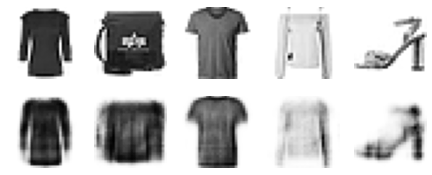

In [17]:
show_reconstructions(tied_ae)
plt.show()

### Training One Autoencoder at a Time

Rather than training the whole stacked autoencoder in one go like we just did, it is possible to train one shallow autoencoder at a time, then stack all of them into a single stacked autoencoder (hence the name), as shown in Figure 17-7. This technique is not used as much these days, but we may still run into papers that talk about "greedy layerwise training", so it’s good to know what it means.

![](https://i.ibb.co/qd9jXYK/one-autoencoder-at-a-time.png)

During the first phase of training, the first autoencoder learns to reconstruct the inputs. Then we encode the whole training set using this first autoencoder, and this gives us a new (compressed) training set. We then train a second autoencoder on this new dataset. This is the second phase of training. Finally, we build a big sandwich using all these autoencoders, as shown in Figure 17-7 (i.e., we first stack the hidden layers of each autoencoder, then the output layers in reverse order). This gives us the final stacked autoencoder (see the "Training One Autoencoder at a Time" section in this [notebook](https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb) for an implementation). We could easily train more autoencoders this way, building a very deep stacked autoencoder.

As we discussed earlier, one of the triggers of the current tsunami of interest in Deep Learning was the discovery in 2006 by Geoffrey Hinton et al. that deep neural networks can be pretrained in an unsupervised fashion , using this greedy layerwise approach ([paper](https://www.cs.toronto.edu/~hinton/absps/ncfast.pdf)). They used restricted Boltzmann machines (RBMs) for this purpose, but in 2007 Yoshua Bengio et al. showed that autoencoders worked just as well ([paper](https://papers.nips.cc/paper/3048-greedy-layer-wise-training-of-deep-networks.pdf)). For several years this was the only efficient way to train deep nets, until many of the techniques we have already in the previous notebooks made it possible to just train a deep net in one shot.

Autoencoders are not limited to dense networks: we can also build convolutional autoencoders, or even recurrent autoencoders. Let’s look at these now.


## Convolutional Autoencoders

If we are dealing with images, then the autoencoders we have seen so far will not work well (unless the images are very small): as we saw in the notebook [Introduction to CNNs](https://github.com/victorviro/Deep_learning_python/blob/master/Introduction_to_CNNs.ipynb), convolutional neural networks are far better suited than dense networks to work with images. So if we want to build an autoencoder for images (e.g., for unsupervised pretraining or dimensionality reduction), we will need to build a [convolutional autoencoder](http://people.idsia.ch/~ciresan/data/icann2011.pdf). The encoder is a regular CNN composed of convolutional layers and pooling layers. It typically reduces the spatial dimensionality of the inputs (i.e., height and width) while increasing the depth (i.e., the number of feature maps). The decoder must do the reverse (upscale the image and reduce its depth back to the original dimensions), and for this we can use transpose convolutional layers (alternatively, we could combine upsampling layers with convolutional layers). Here is a simple convolutional autoencoder for Fashion-MNIST with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders):

In [18]:
tf.random.set_seed(42)
np.random.seed(42)

conv_encoder = keras.models.Sequential([
    keras.layers.Reshape([28, 28, 1], input_shape=[28, 28]),
    keras.layers.Conv2D(16, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(32, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, kernel_size=3, padding="SAME", activation="selu"),
    keras.layers.MaxPool2D(pool_size=2)
])
conv_decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding="VALID", activation="selu",
                                 input_shape=[3, 3, 64]),
    keras.layers.Conv2DTranspose(16, kernel_size=3, strides=2, padding="SAME", activation="selu"),
    keras.layers.Conv2DTranspose(1, kernel_size=3, strides=2, padding="SAME", activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
conv_ae = keras.models.Sequential([conv_encoder, conv_decoder])

In [19]:
conv_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                metrics=[rounded_accuracy])
history = conv_ae.fit(X_train, X_train, epochs=5,
                      validation_data=(X_valid, X_valid))

Epoch 1/5
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3018 - rounded_accuracy: 0.9187 - val_loss: 0.2854 - val_rounded_accuracy: 0.9274
Epoch 2/5
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2756 - rounded_accuracy: 0.9413 - val_loss: 0.2729 - val_rounded_accuracy: 0.9457
Epoch 3/5
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2708 - rounded_accuracy: 0.9461 - val_loss: 0.2696 - val_rounded_accuracy: 0.9496
Epoch 4/5
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2682 - rounded_accuracy: 0.9489 - val_loss: 0.2686 - val_rounded_accuracy: 0.9491
Epoch 5/5
1719/1719 [==============================] - 6s 4ms/step - loss: 0.2664 - rounded_accuracy: 0.9509 - val_loss: 0.2675 - val_rounded_accuracy: 0.9501


In [20]:
conv_encoder.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 3, 3, 64)         

In [21]:
conv_decoder.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose (Conv2DTran (None, 7, 7, 32)          18464     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 14, 14, 16)        4624      
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 28, 28, 1)         145       
_________________________________________________________________
reshape_2 (Reshape)          (None, 28, 28)            0         
Total params: 23,233
Trainable params: 23,233
Non-trainable params: 0
_________________________________________________________________


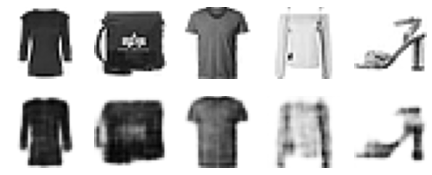

In [22]:
show_reconstructions(conv_ae)
plt.show()

## Recurrent Autoencoders

If we want to build an autoencoder for sequences, such as time series or text (e.g., for unsupervised learning or dimensionality reduction), then recurrent neural networks (see notebook [Introduction to RNNs](https://github.com/victorviro/Deep_learning_python/blob/master/Introduction_to_RNNs.ipynb)) may be better suited than dense networks. Building a recurrent autoencoder is straightforward: the encoder is typically a sequence-to-vector RNN which compresses the input sequence down to a single vector. The decoder is a vector-to-sequence RNN that does the reverse:

In [23]:
recurrent_encoder = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=[None, 28]),
    keras.layers.LSTM(30)
])
recurrent_decoder = keras.models.Sequential([
    keras.layers.RepeatVector(28, input_shape=[30]),
    keras.layers.LSTM(100, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(28, activation="sigmoid"))
])
recurrent_ae = keras.models.Sequential([recurrent_encoder, recurrent_decoder])


In [24]:
recurrent_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(0.1),
                     metrics=[rounded_accuracy])
history = recurrent_ae.fit(X_train, X_train, epochs=10, validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.5192 - rounded_accuracy: 0.7492 - val_loss: 0.4581 - val_rounded_accuracy: 0.8081
Epoch 2/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.4050 - rounded_accuracy: 0.8432 - val_loss: 0.3744 - val_rounded_accuracy: 0.8681
Epoch 3/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3653 - rounded_accuracy: 0.8710 - val_loss: 0.3604 - val_rounded_accuracy: 0.8766
Epoch 4/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3508 - rounded_accuracy: 0.8809 - val_loss: 0.3524 - val_rounded_accuracy: 0.8772
Epoch 5/10
1719/1719 [==============================] - 15s 9ms/step - loss: 0.3405 - rounded_accuracy: 0.8875 - val_loss: 0.3361 - val_rounded_accuracy: 0.8922
Epoch 6/10
1719/1719 [==============================] - 16s 9ms/step - loss: 0.3335 - rounded_accuracy: 0.8922 - val_loss: 0.3307 - val_rounded_accuracy: 0.8963
Epoch 7/10
1719/1719 [============

This recurrent autoencoder can process sequences of any length, with 28 dimensions per time step. Conveniently, this means it can process Fashion-MNIST images by treating each image as a sequence of rows: at each time step, the RNN will process a single row of 28 pixels. Obviously, we could use a recurrent autoencoder for any kind of sequence. Note that we use a `RepeatVector` layer as the first layer of the decoder, to ensure that its input vector gets fed to the decoder at each time step.

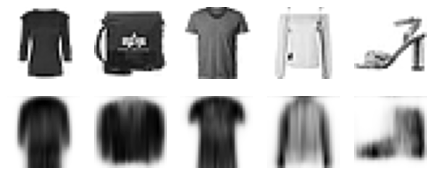

In [25]:
show_reconstructions(recurrent_ae)
plt.show()

Let’s step back for a second. So far we have seen various kinds of autoencoders (basic, stacked, convolutional, and recurrent), and we have looked at how to train them (either in one shot or layer by layer). We also looked at a couple applications: data visualization and unsupervised pretraining.

Up to now, in order to force the autoencoder to learn interesting features, we have limited the size of the coding layer, making it undercomplete. There are actually many other kinds of constraints that can be used, including ones that allow the coding layer to be just as large as the inputs, or even larger, resulting in an overcomplete autoencoder. Let’s look at some of those approaches now.

## Denoising Autoencoders

Another way to force the autoencoder to learn useful features is to add noise to its inputs, training it to recover the original, noise-free inputs. This idea has been around since the 1980s (e.g., it is mentioned in Yann LeCun’s 1987 master’s thesis). In a 2008 [paper](https://www.iro.umontreal.ca/~vincentp/Publications/denoising_autoencoders_tr1316.pdf), Pascal Vincent et al. showed that autoencoders could also be used for feature extraction. In a 2010 [paper](https://jmlr.csail.mit.edu/papers/v11/vincent10a), Vincent et al. introduced *stacked denoising autoencoders*.

The noise can be pure Gaussian noise added to the inputs, or it can be randomly switched-off inputs, just like in dropout (introduced in the notebook [Regularization techniques for deep ANNs](https://github.com/victorviro/Deep_learning_python/blob/master/Regularization_DNNs.ipynb)). Figure 17-8 shows both options.

![](https://i.ibb.co/DrCkXqD/denoising-autoencoders.png)

The implementation is straightforward: it is a regular stacked autoencoder with an additional `Dropout` layer applied to the encoder’s inputs (or we could use a `GaussianNoise` layer instead). Recall that the `Dropout` layer is only active during training (and so is the `GaussianNoise` layer):

In [26]:
tf.random.set_seed(42)
np.random.seed(42)

denoising_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dropout(0.5), # keras.layers.GaussianNoise(0.2),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(30, activation="selu")
])
denoising_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[30]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
denoising_ae = keras.models.Sequential([denoising_encoder, denoising_decoder])
denoising_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
history = denoising_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3568 - rounded_accuracy: 0.8710 - val_loss: 0.3200 - val_rounded_accuracy: 0.9041
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3182 - rounded_accuracy: 0.9032 - val_loss: 0.3125 - val_rounded_accuracy: 0.9110
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3128 - rounded_accuracy: 0.9075 - val_loss: 0.3075 - val_rounded_accuracy: 0.9153
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3092 - rounded_accuracy: 0.9102 - val_loss: 0.3041 - val_rounded_accuracy: 0.9178
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3067 - rounded_accuracy: 0.9123 - val_loss: 0.3015 - val_rounded_accuracy: 0.9193
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3048 - rounded_accuracy: 0.9139 - val_loss: 0.3014 - val_rounded_accuracy: 0.9173
Epoch 7/10
1719/1719 [==================

The next figure shows a few noisy images (with half the pixels turned off), and the images reconstructed by the dropout-based denoising autoencoder. Notice how the autoencoder guesses details that are actually not in the input, such as the top of the white shirt (bottom row, fourth image). As we can see, not only can denoising autoencoders be used for data visualization or unsupervised pretraining, like the other autoencoders we’ve discussed so far, but they can also be used quite simply and efficiently to remove noise from images.

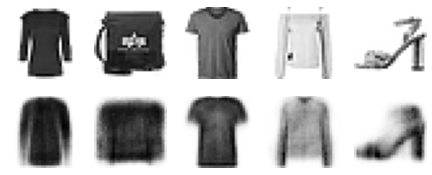

In [27]:
tf.random.set_seed(42)
np.random.seed(42)

noise = keras.layers.Dropout(0.5) # keras.layers.GaussianNoise(0.2)
show_reconstructions(denoising_ae, noise(X_valid, training=True))
plt.show()

## Sparse Autoencoders

Another kind of constraint that often leads to good feature extraction is *sparsity*: by adding an appropriate term to the cost function, the autoencoder is pushed to reduce the number of active neurons in the coding layer. For example, it may be pushed to have on average only 5% significantly active neurons in the coding layer. This forces the autoencoder to represent each input as a combination of a small number of activations. As a result, each neuron in the coding layer typically ends up representing a useful feature.

A simple approach is to use the sigmoid activation function in the coding layer (to constrain the codings to values between 0 and 1), use a large coding layer (e.g., with 300 units), and add some $l_1$ regularization to the coding layer’s activations (the decoder is just a regular decoder):

In [28]:
tf.random.set_seed(42)
np.random.seed(42)

sparse_l1_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid"),
    keras.layers.ActivityRegularization(l1=1e-3) 
                                                  
])
sparse_l1_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_l1_ae = keras.models.Sequential([sparse_l1_encoder, sparse_l1_decoder])

This `ActivityRegularization` layer just returns its inputs, but as a side effect it adds a training loss equal to the sum of absolute values of its inputs (this layer only has an effect during training). Equivalently, we could remove the `ActivityRegularization` layer and set `activity_regularizer=keras.regularizers.l1(1e-3`) in the previous layer. This penalty will encourage the neural network to produce codings close to 0, but since it will also be penalized if it does not reconstruct the inputs correctly, it will have to output at least a few nonzero values. Using the $l_1$ norm rather than the $l_2$ norm will push the neural network to preserve the most important codings while eliminating the ones that are not needed for the input image (rather than just reducing all codings).




In [29]:
sparse_l1_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
                     metrics=[rounded_accuracy])
history = sparse_l1_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.4310 - rounded_accuracy: 0.8129 - val_loss: 0.3808 - val_rounded_accuracy: 0.8555
Epoch 2/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3690 - rounded_accuracy: 0.8689 - val_loss: 0.3638 - val_rounded_accuracy: 0.8741
Epoch 3/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3545 - rounded_accuracy: 0.8799 - val_loss: 0.3502 - val_rounded_accuracy: 0.8857
Epoch 4/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3437 - rounded_accuracy: 0.8876 - val_loss: 0.3418 - val_rounded_accuracy: 0.8898
Epoch 5/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3372 - rounded_accuracy: 0.8920 - val_loss: 0.3368 - val_rounded_accuracy: 0.8949
Epoch 6/10
1719/1719 [==============================] - 5s 3ms/step - loss: 0.3320 - rounded_accuracy: 0.8968 - val_loss: 0.3316 - val_rounded_accuracy: 0.8992
Epoch 7/10
1719/1719 [==================

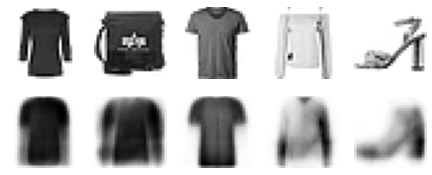

In [30]:
show_reconstructions(sparse_l1_ae)

Another approach, which often yields better results, is to measure the actual sparsity of the coding layer at each training iteration, and penalize the model when the measured sparsity differs from a target sparsity. We do so by computing the average activation of each neuron in the coding layer, over the whole training batch. The batch size must not be too small, or else the mean will not be accurate.

Once we have the mean activation per neuron, we want to penalize the neurons that are too active, or not active enough, by adding a *sparsity* loss to the cost function. For example, if we measure that a neuron has an average activation of 0.3, but the target sparsity is 0.1, it must be penalized to activate less. One approach could be simply adding the squared error $(0.3- 
0.1)^2$ to the cost function, but in practice a better approach is to use the Kullback–Leibler (KL) divergence, which has much stronger gradients than the mean squared error, as we can see in the next figure.

(0.0, 1.0, 0.0, 0.95)

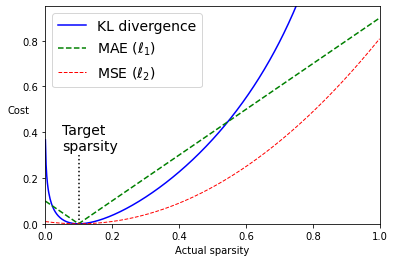

In [31]:
p = 0.1
q = np.linspace(0.001, 0.999, 500)
kl_div = p * np.log(p / q) + (1 - p) * np.log((1 - p) / (1 - q))
mse = (p - q)**2
mae = np.abs(p - q)
plt.plot([p, p], [0, 0.3], "k:")
plt.text(0.05, 0.32, "Target\nsparsity", fontsize=14)
plt.plot(q, kl_div, "b-", label="KL divergence")
plt.plot(q, mae, "g--", label=r"MAE ($\ell_1$)")
plt.plot(q, mse, "r--", linewidth=1, label=r"MSE ($\ell_2$)")
plt.legend(loc="upper left", fontsize=14)
plt.xlabel("Actual sparsity")
plt.ylabel("Cost", rotation=0)
plt.axis([0, 1, 0, 0.95])

Given two discrete probability distributions $P$ and $Q$, the KL divergence between these distributions, noted $D_{KL}(P||Q)$, can be computed using the next equation.

$$D_{KL}(P||Q)=\sum_{i}P(i)\text{log}\frac{P(i)}{Q(i)}$$

In our case, we want to measure the divergence between the target probability $p$ that a neuron in the coding layer will activate and the actual probability $q$ (i.e., the mean activation over the training batch). So the KL divergence simplifies to the equation:

$$D_{KL}(p||q)=p\text{ log}\frac{p}{q}+(1-p)\text{ log}\frac{1-p}{1-q}$$

Once we have computed the sparsity loss for each neuron in the coding layer, we sum up these losses and add the result to the cost function. In order to control the relative importance of the sparsity loss and the reconstruction loss, we can multiply the sparsity loss by a sparsity weight hyperparameter. If this weight is too high, the model will stick closely to the target sparsity, but it may not reconstruct the inputs properly, making the model useless. Conversely, if it is too low, the model will mostly ignore the sparsity objective and will not learn any interesting features.

We now have all we need to implement a sparse autoencoder based on the KL divergence. First, let’s create a custom regularizer to apply KL divergence regularization:

In [32]:
K = keras.backend
kl_divergence = keras.losses.kullback_leibler_divergence

class KLDivergenceRegularizer(keras.regularizers.Regularizer):
    def __init__(self, weight, target=0.1):
        self.weight = weight
        self.target = target
    def __call__(self, inputs):
        mean_activities = K.mean(inputs, axis=0)
        return self.weight * (
            kl_divergence(self.target, mean_activities) +
            kl_divergence(1. - self.target, 1. - mean_activities))

Now we can build the sparse autoencoder, using the `KLDivergenceRegularizer` for the coding layer’s activations:

In [33]:
tf.random.set_seed(42)
np.random.seed(42)

kld_reg = KLDivergenceRegularizer(weight=0.05, target=0.1)
sparse_kl_encoder = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(100, activation="selu"),
    keras.layers.Dense(300, activation="sigmoid", activity_regularizer=kld_reg)
])
sparse_kl_decoder = keras.models.Sequential([
    keras.layers.Dense(100, activation="selu", input_shape=[300]),
    keras.layers.Dense(28 * 28, activation="sigmoid"),
    keras.layers.Reshape([28, 28])
])
sparse_kl_ae = keras.models.Sequential([sparse_kl_encoder, sparse_kl_decoder])
sparse_kl_ae.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0),
              metrics=[rounded_accuracy])
history = sparse_kl_ae.fit(X_train, X_train, epochs=10,
                           validation_data=(X_valid, X_valid))

Epoch 1/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.4150 - rounded_accuracy: 0.8121 - val_loss: 0.3716 - val_rounded_accuracy: 0.8564
Epoch 2/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3531 - rounded_accuracy: 0.8763 - val_loss: 0.3442 - val_rounded_accuracy: 0.8847
Epoch 3/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3340 - rounded_accuracy: 0.8918 - val_loss: 0.3293 - val_rounded_accuracy: 0.8975
Epoch 4/10
1719/1719 [==============================] - 6s 3ms/step - loss: 0.3224 - rounded_accuracy: 0.9018 - val_loss: 0.3213 - val_rounded_accuracy: 0.9043
Epoch 5/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3169 - rounded_accuracy: 0.9063 - val_loss: 0.3171 - val_rounded_accuracy: 0.9078
Epoch 6/10
1719/1719 [==============================] - 6s 4ms/step - loss: 0.3135 - rounded_accuracy: 0.9093 - val_loss: 0.3140 - val_rounded_accuracy: 0.9105
Epoch 7/10
1719/1719 [==================

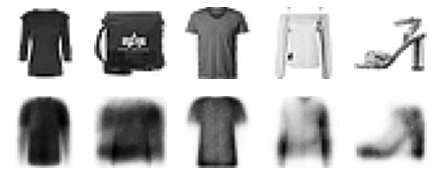

In [34]:
show_reconstructions(sparse_kl_ae)

After training this sparse autoencoder on Fashion MNIST, the activations of the neurons in the coding layer are mostly close to 0 (about 70% of all activations are lower than 0.1), and all neurons have a mean activation around 0.1 (about 90% of all neurons have a mean activation between 0.1 and 0.2), as shown in the next figure.

In [35]:
def plot_percent_hist(ax, data, bins):
    counts, _ = np.histogram(data, bins=bins)
    widths = bins[1:] - bins[:-1]
    x = bins[:-1] + widths / 2
    ax.bar(x, counts / len(data), width=widths*0.8)
    ax.xaxis.set_ticks(bins)
    ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(
        lambda y, position: "{}%".format(int(np.round(100 * y)))))
    ax.grid(True)

def plot_activations_histogram(encoder, height=1, n_bins=10):
    X_valid_codings = encoder(X_valid).numpy()
    activation_means = X_valid_codings.mean(axis=0)
    mean = activation_means.mean()
    bins = np.linspace(0, 1, n_bins + 1)

    fig, [ax1, ax2] = plt.subplots(figsize=(10, 3), nrows=1, ncols=2, sharey=True)
    plot_percent_hist(ax1, X_valid_codings.ravel(), bins)
    ax1.plot([mean, mean], [0, height], "k--", label="Overall Mean = {:.2f}".format(mean))
    ax1.legend(loc="upper center", fontsize=14)
    ax1.set_xlabel("Activation")
    ax1.set_ylabel("% Activations")
    ax1.axis([0, 1, 0, height])
    plot_percent_hist(ax2, activation_means, bins)
    ax2.plot([mean, mean], [0, height], "k--")
    ax2.set_xlabel("Neuron Mean Activation")
    ax2.set_ylabel("% Neurons")
    ax2.axis([0, 1, 0, height])

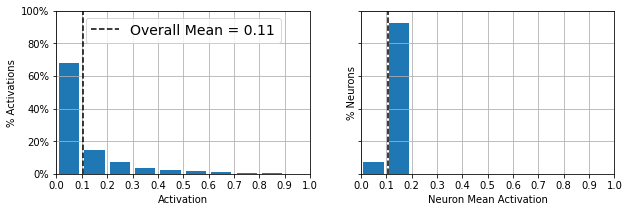

In [36]:
plot_activations_histogram(sparse_kl_encoder)

## Variational Autoencoders

Another important category of autoencoders was introduced in 2013 by Diederik Kingma and Max Welling ([Auto-Encoding Variational Bayes](https://arxiv.org/abs/1312.6114)) and quickly became one of the most popular types of autoencoders: *variational autoencoders*.

They are quite different from all the autoencoders we have discussed so far, in these particular ways:

- They are *probabilistic autoencoders*, meaning that their outputs are partly determined by chance, even after training (as opposed to denoising autoencoders, which use randomness only during training).

- Most importantly, they are *generative autoencoders*, meaning that they can generate new instances that look like they were sampled from the training set.


Both these properties make them rather similar to RBMs, but they are easier to train, and the sampling process is much faster (with RBMs we need to wait for the network to stabilize into a "thermal equilibrium" before we can sample a new instance). Indeed, as their name suggests, variational autoencoders perform variational Bayesian inference, which is an efficient way to perform approximate Bayesian inference.

Let’s take a look at how they work. Figure 17-12 (left) shows a variational autoencoder. We can recognize the basic structure of all autoencoders, with an encoder followed by a decoder (in this example, they both have two hidden layers), but there is a twist: instead of directly producing a coding for a given input, the encoder produces a *mean coding* $\boldsymbol{\mu}$ and a standard deviation $\boldsymbol{\sigma}$. The actual coding is then sampled randomly from a Gaussian distribution with mean $\boldsymbol{\mu}$ and standard deviation $\boldsymbol{\sigma}$. After that the decoder decodes the sampled coding normally. The right part of the diagram shows a training instance going through this autoencoder. First, the encoder produces $\boldsymbol{\mu}$ and $\boldsymbol{\sigma}$, then a coding is sampled randomly (notice that it is not exactly located at $\boldsymbol{\mu}$), and finally this coding is decoded; the final output resembles the training instance.

![](https://i.ibb.co/hCfs39C/variational-autoencoder.png)

As we can see in the diagram, although the inputs may have a very convoluted distribution, a variational autoencoder tends to produce codings that look as though they were sampled from a simple Gaussian distribution: during training, the cost function (discussed next) pushes the codings to gradually migrate within the coding space (also called the *latent space*) to end up looking like a cloud of Gaussian points. One great consequence is that after training a variational autoencoder, we can very easily generate a new instance: we just sample a random coding from the Gaussian distribution, decode it, and voilà!

Now, let’s look at the cost function. It is composed of two parts. The first is the usual reconstruction loss that pushes the autoencoder to reproduce its inputs (we can use cross entropy for this, as discussed earlier). The second is the *latent loss* that pushes the autoencoder to have codings that look as though they were sampled from a simple Gaussian distribution: it is the KL divergence between the target distribution (i.e., the Gaussian distribution) and the actual distribution of the codings. The math is a bit more complex than with the sparse autoencoder, in particular because of the Gaussian noise, which limits the amount of information that can be transmitted to the coding layer (thus pushing the autoencoder to learn useful features). Luckily, the equations simplify, so the latent loss can be computed quite simply using the next equation:

$$\mathcal{L}=-\frac{1}{2}\sum_{i=1}^{n}[\ 1+\text{log}(\sigma_i^2)-\sigma_i^2-\mu_i^2]\ $$

In this equation, $\mathcal{L}$ is the latent loss, $n$ is the codings’ dimensionality, and $\mu_i$ and $\sigma_i$ are the mean and standard deviation of the $i^{\text{th}}$ component of the codings. The vectors $\boldsymbol{\mu}$ and $\boldsymbol{\sigma}$ (which contain all the $\mu_i$ and $\sigma_i$) are output by the encoder, as shown in Figure 17-12 (left).

A common tweak to the variational autoencoder’s architecture is to make the encoder output $\boldsymbol{\gamma}=\text{log}(\boldsymbol{\sigma}^2)$ rather than $\sigma$. The latent loss can then be computed as shown in the next equation. 
$$\mathcal{L}=-\frac{1}{2}\sum_{i=1}^{n}[\ 1+ \gamma_i - \text{exp}(\gamma_i)-\mu_i^2]\ $$

This approach is more numerically stable and speeds up training.

Let’s start building a variational autoencoder for Fashion MNIST (as shown in Figure 17-12, but using the $\boldsymbol{\gamma}$ tweak). First, we will need a custom layer to sample the codings, given $\boldsymbol{\mu}$ and $\boldsymbol{\gamma}$:

In [37]:
class Sampling(keras.layers.Layer):
    def call(self, inputs):
        mean, log_var = inputs
        return K.random_normal(tf.shape(log_var)) * K.exp(log_var / 2) + mean

This Sampling layer takes two inputs: `mean`($\boldsymbol{\mu}$) and `log_var`($\boldsymbol{\gamma}$). It uses the function `K.random_normal()` to sample a random vector (of the same shape as $\boldsymbol{\gamma}$) from the Normal distribution, with mean 0 and standard deviation 1. Then it multiplies it by $\text{exp}(\frac{\boldsymbol{\gamma}}{2})$ (which is equal to $\boldsymbol{\sigma}$, as we can verify), and finally it adds $\boldsymbol{\mu}$ and returns the result. This samples a codings vector from the Normal distribution with mean $\boldsymbol{\mu}$ and standard deviation $\boldsymbol{\sigma}$.

Next, we can create the encoder, using the Functional API because the model is not entirely sequential:

In [38]:
tf.random.set_seed(42)
np.random.seed(42)

codings_size = 10

inputs = keras.layers.Input(shape=[28, 28])
z = keras.layers.Flatten()(inputs)
z = keras.layers.Dense(150, activation="selu")(z)
z = keras.layers.Dense(100, activation="selu")(z)
codings_mean = keras.layers.Dense(codings_size)(z)  # μ
codings_log_var = keras.layers.Dense(codings_size)(z)  # γ
codings = Sampling()([codings_mean, codings_log_var])
variational_encoder = keras.models.Model(
    inputs=[inputs], outputs=[codings_mean, codings_log_var, codings])

Note that the `Dense` layers that output `codings_mean`($\boldsymbol{\mu}$) and `codings_log_var`($\boldsymbol{\gamma}$) have the same inputs (i.e., the outputs of the second `Dense` layer). We then pass both `codings_mean` and `codings_log_var` to the `Sampling` layer. Finally, the `variational_encoder` model has three outputs, in case we want to inspect the values of `codings_mean` and `codings_log_var`. The only output we will use is the last one (`codings`). Now let’s build the decoder:

In [39]:
decoder_inputs = keras.layers.Input(shape=[codings_size])
x = keras.layers.Dense(100, activation="selu")(decoder_inputs)
x = keras.layers.Dense(150, activation="selu")(x)
x = keras.layers.Dense(28 * 28, activation="sigmoid")(x)
outputs = keras.layers.Reshape([28, 28])(x)
variational_decoder = keras.models.Model(inputs=[decoder_inputs], outputs=[outputs])

For this decoder, we could have used the Sequential API instead of the Functional API, since it is really just a simple stack of layers, virtually identical to many of the decoders we have built so far. Finally, let’s build the variational autoencoder model:

In [40]:
_, _, codings = variational_encoder(inputs)
reconstructions = variational_decoder(codings)
variational_ae = keras.models.Model(inputs=[inputs], outputs=[reconstructions])

Note that we ignore the first two outputs of the encoder (we only want to feed the codings to the decoder). Lastly, we must add the latent loss and the reconstruction loss:

In [41]:
latent_loss = -0.5 * K.sum(
    1 + codings_log_var - K.exp(codings_log_var) - K.square(codings_mean),
    axis=-1)
variational_ae.add_loss(K.mean(latent_loss) / 784.)
variational_ae.compile(loss="binary_crossentropy", optimizer="rmsprop",
                       metrics=[rounded_accuracy])

We first apply the last equation showed to compute the latent loss for each instance in the batch (we sum over the last axis). Then we compute the mean loss over all the instances in the batch, and we divide the result by 784 to ensure it has the appropriate scale compared to the reconstruction loss. Indeed, the variational autoencoder’s reconstruction loss is supposed to be the sum of the pixel reconstruction errors, but when Keras computes the `"binary_crossentropy"` loss, it computes the mean over all 784 pixels, rather than the sum. So, the reconstruction loss is 784 times smaller than we need it to be. We could define a custom loss to compute the sum rather than the mean, but it is simpler to divide the latent loss by 784 (the final loss will be 784 times smaller than it should be, but this just means that we should use a larger learning rate).

Note that we use the `RMSprop` optimizer, which works well in this case. And finally we can train the autoencoder!

In [42]:
history = variational_ae.fit(X_train, X_train, epochs=25, batch_size=128,
                             validation_data=[X_valid, X_valid])

Epoch 1/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3896 - rounded_accuracy: 0.8609 - val_loss: 0.0207 - val_rounded_accuracy: 0.0000e+00
Epoch 2/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3426 - rounded_accuracy: 0.8979 - val_loss: 0.0194 - val_rounded_accuracy: 0.0000e+00
Epoch 3/25
430/430 [==============================] - 2s 6ms/step - loss: 0.3326 - rounded_accuracy: 0.9055 - val_loss: 0.0188 - val_rounded_accuracy: 0.0000e+00
Epoch 4/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3278 - rounded_accuracy: 0.9092 - val_loss: 0.0184 - val_rounded_accuracy: 0.0000e+00
Epoch 5/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3247 - rounded_accuracy: 0.9120 - val_loss: 0.0190 - val_rounded_accuracy: 0.0000e+00
Epoch 6/25
430/430 [==============================] - 2s 5ms/step - loss: 0.3225 - rounded_accuracy: 0.9137 - val_loss: 0.0195 - val_rounded_accuracy: 0.0000e+00
Epoch 7/25
430/430 [========

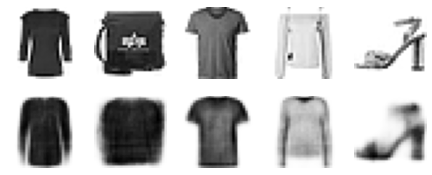

In [43]:
show_reconstructions(variational_ae)

### Generating Fashion MNIST Images

Now let’s use this variational autoencoder to generate images that look like fashion items. All we need to do is sample random codings from a Gaussian distribution and decode them:

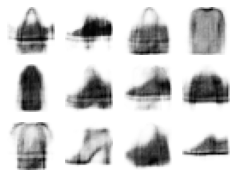

In [44]:
tf.random.set_seed(42)

codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()

def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

plot_multiple_images(images, 4)

[]()

The majority of these images look fairly convincing, if a bit too fuzzy. The rest are not great, but don’t be too harsh on the autoencoder—it only had a few minutes to learn! Give it a bit more fine-tuning and training time, and those images should look better.

Variational autoencoders make it possible to perform *semantic interpolation*: instead of interpolating two images at the pixel level (which would look as if the two images were overlaid), we can interpolate at the codings level. We first run both images through the encoder, then we interpolate the two codings we get, and finally we decode the interpolated codings to get the final image. It will look like a regular Fashion MNIST image, but it will be an intermediate between the original images. In the following code example, we take the 12 codings we just generated, we organize them in a $3 \times 4$ grid, and we use TensorFlow’s `tf.image.resize()` function to resize this grid to $5 \times 7$. By default, the `resize()` function will perform bilinear interpolation, so every other row and column will contain interpolated codings. We then use the decoder to produce all the images:

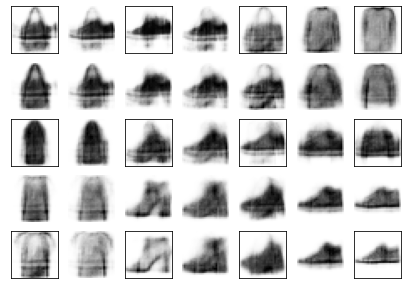

In [45]:
tf.random.set_seed(42)
np.random.seed(42)

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

plt.figure(figsize=(7, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")

The figure shows the resulting images. The original images are framed, and the rest are the result of semantic interpolation between the nearby images. Notice, for example, how the shoe in the fourth row and fifth column is a nice interpolation between the two shoes located above and below it.


For several years, variational autoencoders were quite popular, but GANs eventually took the lead, in particular because they are capable of generating much more realistic and crisp images. So we will turn our attention to GANs in the next notebook.

# References

- [Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow](https://www.oreilly.com/library/view/hands-on-machine-learning/9781492032632/)

- [Github: Hands-On Machine Learning with Scikit-Learn, Keras, and TensorFlow](https://github.com/ageron/handson-ml2)

- [Intro to Autoencoders with TensorFlow](https://www.tensorflow.org/tutorials/generative/autoencoder)

- [Building Autoencoders in Keras](https://blog.keras.io/building-autoencoders-in-keras.html)

- [Variational AutoEncoder with Keras](https://keras.io/examples/generative/vae/)

- [Convolutional Variational Autoencoder with TensorFlow](https://www.tensorflow.org/tutorials/generative/cvae)

- [Autoencoders with Keras ](https://www.pyimagesearch.com/2020/02/17/autoencoders-with-keras-tensorflow-and-deep-learning/)